# NiN

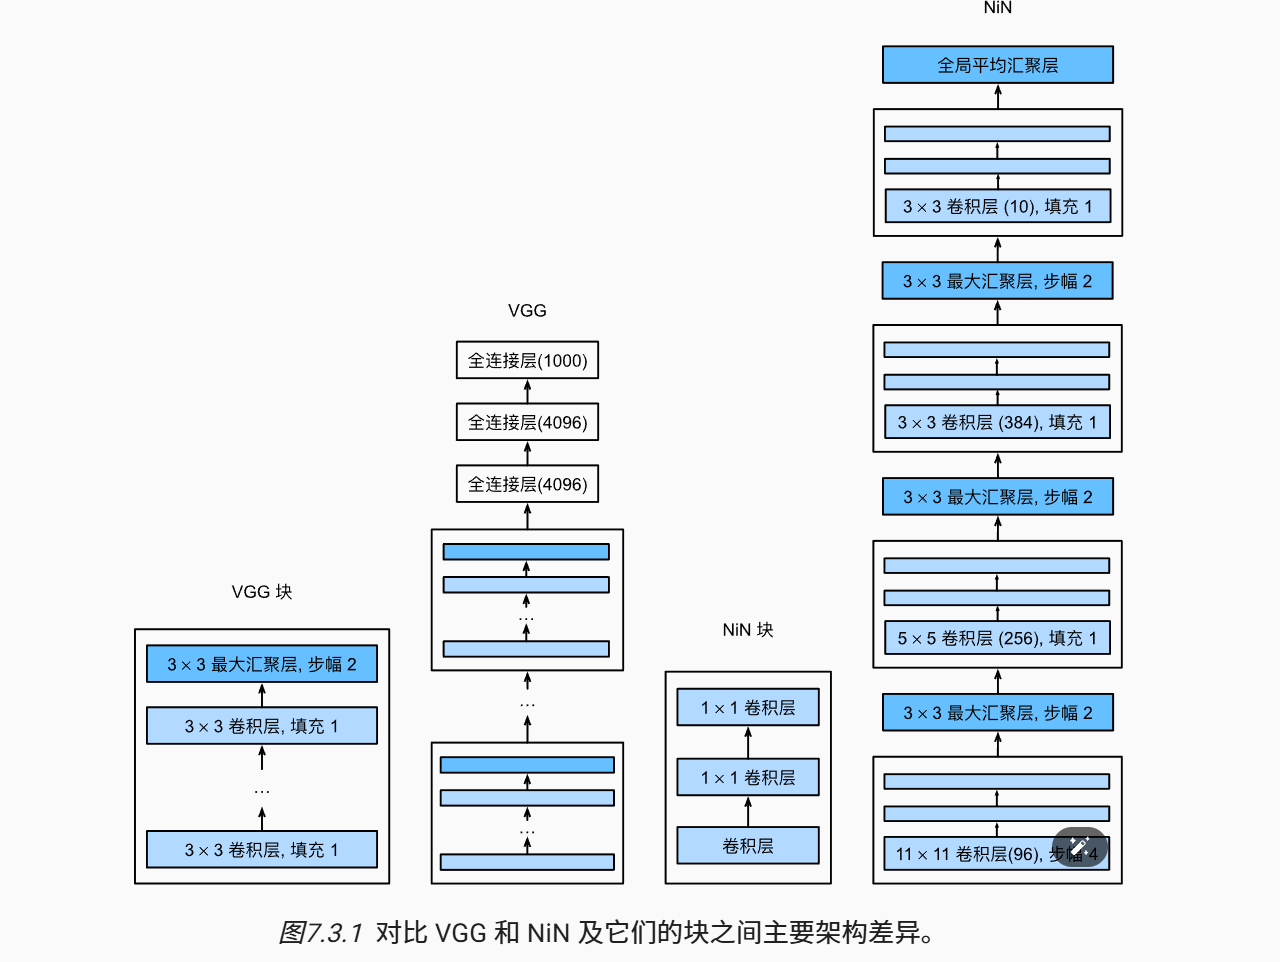

NiN和AlexNet/VGG的不同是；
* AlexNet和VGG通过一系列的卷积层和汇聚层提取空间特征，然后通过全连接层对特征的表征进行处理
* NiN在过程的早期通过1 * 1的卷积层实现全连接层的效果（相当于对每个像素位置上独立作用的全连接层）
* 从另一个角度看，1 * 1将空间维度的每个像素视为单个样本，将通道维度视为不同特征

NiN的好处：
* 移除全连接层可以减少过拟合，同时显著减少NiN的参数

In [1]:
# NiN块从一个普通卷积层开始，后面是两个1 * 1的卷积层
# 这两个1 * 1卷积层充当带有ReLU激活函数的逐像素全连接层
# 第一层的卷积窗口形状通常由用户设置，随后的卷积窗口形状固定为1 * 1

In [2]:
import torch
from torch import nn
from d2l import torch as d2l



In [3]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3,stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),   # 将输入特征图的高度和宽度都调整为1，保留通道维度
    nn.Flatten()  # 将四维输出转化为二维，形状为（批量大小，10）
)

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.562, train acc 0.787, test acc 0.779
1528.5 examples/sec on cuda:0


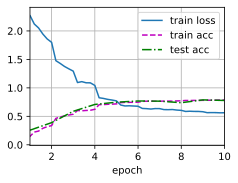

In [6]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())